# DAB-SMOTE STATISTICAL BENCHMARK EVALUATION #
## Authors: Unai Lalana Morales & José Antonio Sanz Delgado ##

### Imports ###

In [79]:
#Sistem imports
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..\..', 'classes')))

#Local imports
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.metrics import f1_score
from statds.no_parametrics import friedman_aligned_ranks, holm
import matplotlib.pyplot as plt

In [80]:
%load_ext autoreload
%autoreload 2
import DAB_SMOTE
from dataset import dataReading

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Functions ###

In [81]:
import math
from statds.no_parametrics import stats
def wilconxon(dataset: pd.DataFrame, alpha: float = 0.1, verbose: bool = False):
    """
    Perform the Wilcoxon signed-rank test. This non-parametric test is used to compare two related samples, matched
    samples, or repeated measurements on a single sample to assess whether their population mean ranks differ. It is
    an alternative to the paired Student's t-test when the data is not normally distributed.

    Parameters
    ----------
    dataset : pandas.DataFrame
        A DataFrame with exactly two columns, each representing a different condition or time point for the same
        subjects.
    alpha : float, optional
        The significance level for the test. Default is 0.05.
    verbose : bool, optional
        If True, prints the detailed results table.

    Returns
    -------
    w_wilcoxon : float
        The Wilcoxon test statistic, which is the smallest of the sums of the positive and negative ranks.
    p_value : float or None
        The p-value for the hypothesis test (only for large sample sizes, otherwise None).
    cv_alpha_selected : float or None
        The critical value for the test at the specified alpha level (only for small sample sizes, otherwise None).
    hypothesis : str
        A string stating the conclusion of the test based on the test statistic, critical value, or p-value and alpha.

    Note
    ----
    The Wilcoxon signed-rank test makes fewer assumptions than the t-test and is appropriate when the data
    are not normally distributed. It ranks the absolute differences between pairs, then compares these ranks.
    The test is sensitive to ties and has different procedures for small and large sample sizes. For large samples,
    the test statistic is approximately normally distributed, allowing the use of normal approximation for p-value
    calculation.
    """
    if dataset.shape[1] != 2:
        raise "Error: The test only needs two samples"

    results_table = dataset.copy()
    columns = list(dataset.columns)
    differences_results = dataset[columns[0]] - dataset[columns[1]]
    absolute_dif = differences_results.abs()
    absolute_dif = absolute_dif.sort_values()
    results_wilconxon = {"index": [], "dif": [], "rank": [], "R": []}
    rank = 0.0
    tied_ranges = not (len(set(absolute_dif)) == absolute_dif.shape[0])
    for index in absolute_dif.index:
        if math.fabs(0 - absolute_dif[index]) < 1e-10:
            continue
        rank += 1.0
        results_wilconxon["index"] += [index]
        results_wilconxon["dif"] += [differences_results[index]]
        results_wilconxon["rank"] += [rank]
        results_wilconxon["R"] += ["+" if differences_results[index] > 0 else "-"]

    df = pd.DataFrame(results_wilconxon)
    df = df.set_index("index")
    df = df.sort_index()
    results_table = pd.concat([results_table, df], axis=1)

    tie_sum = 0

    if tied_ranges:
        vector = [abs(i) for i in results_table["dif"]]

        counts = {}
        for number in vector:
            try:
                counts[number] = counts[number] + 1
            except KeyError:
                counts[number] = 1

        ranks = results_table["rank"].to_numpy()
        for index, number in enumerate(vector):
            if counts[number] > 1:
                rank_sum = sum(ranks[i] for i, x in enumerate(vector) if x == number)
                average_rank = rank_sum / counts[number]
                for i, x in enumerate(vector):
                    if x == number:
                        ranks[i] = average_rank
        tie_sizes = np.array(list(counts.values()))
        tie_sum = (tie_sizes ** 3 - tie_sizes).sum()

    if verbose:
        print(results_table)

    r_plus = results_table[results_table.R == "+"]["rank"].sum()
    r_minus = results_table[results_table.R == "-"]["rank"].sum()

    w_wilcoxon = min([r_plus, r_minus])
    num_problems = results_table.shape[0] - (results_table.R.isna().sum())
    mean_wilcoxon = (num_problems * (num_problems + 1)) / 4.0

    std_wilcoxon = num_problems * (num_problems + 1) * ((2 * num_problems) + 1)
    std_wilcoxon = math.sqrt(std_wilcoxon / 24.0 - (tie_sum / 48))
    z_wilcoxon = (w_wilcoxon - mean_wilcoxon) / std_wilcoxon

    cv_alpha_selected = stats.get_cv_willcoxon(num_problems, alpha)

    p_value = 2 * stats.get_p_value_normal(z_wilcoxon)

    # if num_problems > 25:
    hypothesis = f"Fail to Reject H0 with alpha = {alpha} (Same distributions)"
    if p_value < alpha:
        hypothesis = f"Reject H0 with alpha = {alpha} (Different distributions)"

    return w_wilcoxon, p_value, cv_alpha_selected, hypothesis, r_plus, r_minus

In [82]:
def highlight_max(row):
    values_to_compare = row[1:]
    maximum = max(values_to_compare)
    is_unique = (values_to_compare == maximum).sum() == 1
    styles = []
    for val in values_to_compare:
        if val == maximum:
            color = 'green' if is_unique else 'orange'
            styles.append(f'background-color: {color}; font-weight: bold;')
        else:
            styles.append('')
    return [''] + styles

In [83]:
from tqdm import tqdm

def benchmark(root_path, param_name, methods, fixed_params, selected_columns=None, alpha=0.05):
    dataframe_names = []
    results_per_method = {method: [] for method in methods}
    dirs = [d for d in os.listdir(root_path) if os.path.isdir(os.path.join(root_path, d))]
    for paths in tqdm(dirs, desc="Processing datasets"):
        complete_path = os.path.join(root_path, paths)
        dataframe_names.append(paths)
        train = []
        test = []
        for file in os.listdir(complete_path):
            if "tra.dat" in file:
                train_data = dataReading(complete_path + "/" + file)
                train.append(train_data)
                suffix = file.replace("tra.dat", "")
                test_data = dataReading(complete_path + "/" + suffix + "tst.dat")
                test.append(test_data)
        
        for method in methods:
            f1_scores = []
            for i in range(len(train)):
                dab = DAB_SMOTE.DAB_SMOTE(**{param_name: method}, **fixed_params)
                newX, newY = dab.fit_resample(train[i].data, train[i].target)
                cls = linear_model.LogisticRegression(penalty='l2', solver='lbfgs', max_iter=10000)
                cls.fit(newX, newY)
                predictions = cls.predict(test[i].data)
                f1_scores.append(f1_score(np.array(test[i].target), predictions, pos_label=0))
            results_per_method[method].append(np.mean(f1_scores))

    df_methods = pd.DataFrame(results_per_method)
    df_methods = pd.concat([pd.DataFrame(dataframe_names, columns=["dataset"]), df_methods], axis=1)

    # Test estadístico de Friedman
    if len(methods) > 2:
        print("\n--- Test de Friedman ---")
        rankings, statistic, p_val, critical_value, hypothesis = friedman_aligned_ranks(df_methods.iloc[:, 0:])
        print(f"Friedman statistic: {statistic:.4f}, p-value: {p_val:.4g}, Hypothesis: {hypothesis}")
        print(f"Rankings: {rankings}")

        # Holm post-hoc test if Friedman is significant
        if p_val < alpha:
            print("\n--- Holm Post-hoc Test ---")
            control_method = min(rankings, key=rankings.get)
            num_cases = len(df_methods.iloc[:, 0:])
            holm_results, figure = holm(rankings, num_cases, alpha, control = control_method, type_rank = "Friedman Aligned Ranks")
            if (holm_results["Adjusted p-value"].values < 0.1).all():
                best_method = control_method
            else:
                comps = holm_results["Adjusted p-value"].values >= alpha
                if comps.any():
                    best_method = holm_results["Comparison"].values[comps][0].split("vs")[-1]
            print(f"Best method according to Holm: {best_method}")

        # Wilcoxon test for method pairs (only if there are 2 methods)
    if len(methods) == 2:
        print("\n--- Wilcoxon Test ---")
        w_wilcoxon, p_value, cv_alpha_selected, hypothesis, r_plus, r_minus = wilconxon(df_methods[selected_columns])
        print('{} with p-value {}'.format(hypothesis, p_value))
        print('Ranks: {} {} and {} {}'.format(selected_columns[0], r_plus, selected_columns[1], r_minus))

    return dataframe_names, df_methods


### First benchmark ###
#### k=1 and means solver ####

In [84]:
methods = ["euclidean", "manhattan", "chebyshev"]
fixed_params = {"k": 1}
dataframe_names, dbscan_distances_df_lower_mean = benchmark("./../../data/benchmarks/imb_IRLowerThan9/","distMethod", methods, fixed_params)

Processing datasets: 100%|██████████| 22/22 [01:04<00:00,  2.93s/it]


--- Test de Friedman ---
Friedman statistic: 0.0623, p-value: 0.9693, Hypothesis: Fail to Reject H0 with alpha = 0.05 (Same distributions)
Rankings: {'euclidean': 33.75, 'manhattan': 34.20454545454545, 'chebyshev': 32.54545454545455}


In [85]:
means = dbscan_distances_df_lower_mean.iloc[:, 1:].mean(axis=0)
print("Max mean of F1 scores: ", means.max(), "Method: ", methods[means.argmax()])

means_row = pd.DataFrame([['MEANS'] + means.tolist()], columns=dbscan_distances_df_lower_mean.columns)
dbscan_distances_df_lower_mean_with_means = pd.concat([dbscan_distances_df_lower_mean, means_row], ignore_index=True)
dbscan_distances_df_lower_mean_with_means_color = dbscan_distances_df_lower_mean_with_means.style.apply(highlight_max, axis=1)
dbscan_distances_df_lower_mean_with_means_color

Max mean of F1 scores:  0.7796944052346436 Method:  euclidean


,dataset,euclidean,manhattan,chebyshev
0,ecoli-0_vs_1,0.976369,0.976369,0.975662
1,ecoli1,0.769922,0.769922,0.756427
2,ecoli2,0.708644,0.708644,0.714277
3,ecoli3,0.604589,0.611256,0.600384
4,glass-0-1-2-3_vs_4-5-6,0.832573,0.856210,0.844954
5,glass0,0.644528,0.644528,0.646500
6,glass1,0.576912,0.576912,0.576062
7,glass6,0.812821,0.779487,0.791608
8,haberman,0.466593,0.481590,0.480482
9,iris0,1.000000,1.000000,1.000000


Processing datasets: 100%|██████████| 21/21 [00:39<00:00,  1.90s/it]


--- Test de Friedman ---
Friedman statistic: 9.0295, p-value: 0.01095, Hypothesis: Reject H0 with alpha = 0.05 (Different distributions)
Rankings: {'euclidean': 21.952380952380953, 'manhattan': 32.285714285714285, 'chebyshev': 41.76190476190476}

--- Holm Post-hoc Test ---
Best method according to Holm: euclidean


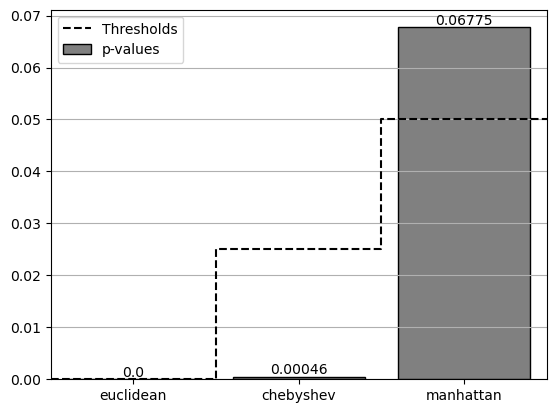

In [86]:
methods = ["euclidean", "manhattan", "chebyshev"]
fixed_params = {"k": 1}
dataframe_names, dbscan_distances_df_higher_mean = benchmark("./../../data/benchmarks/imb_IRHigherThan9p1/","distMethod", methods, fixed_params)

In [87]:
means = dbscan_distances_df_higher_mean.iloc[:, 1:].mean(axis=0)
print("Max mean of F1 scores: ", means.max(), "Method: ", methods[means.argmax()])

means_row = pd.DataFrame([['MEANS'] + means.tolist()], columns=dbscan_distances_df_higher_mean.columns)
dbscan_distances_df_higher_mean_with_means = pd.concat([dbscan_distances_df_higher_mean, means_row], ignore_index=True)
dbscan_distances_df_higher_mean_with_means_color = dbscan_distances_df_higher_mean_with_means.style.apply(highlight_max, axis=1)
dbscan_distances_df_higher_mean_with_means_color

Max mean of F1 scores:  0.453105126903771 Method:  euclidean


,dataset,euclidean,manhattan,chebyshev
0,abalone19,0.056061,0.056221,0.054509
1,abalone9-18,0.428553,0.414661,0.412172
2,ecoli-0-1-3-7_vs_2-6,0.413333,0.413333,0.413333
3,ecoli4,0.791111,0.791111,0.776566
4,glass-0-1-6_vs_2,0.150392,0.098413,0.098413
5,glass-0-1-6_vs_5,0.411429,0.411429,0.411429
6,glass2,0.183725,0.163993,0.163993
7,glass4,0.665714,0.665714,0.599048
8,glass5,0.322222,0.322222,0.322222
9,page-blocks-1-3_vs_4,0.695455,0.695455,0.695455


### Second benchmark ###
#### k=1 and density solver ####

Processing datasets: 100%|██████████| 22/22 [00:53<00:00,  2.43s/it]


--- Test de Friedman ---
Friedman statistic: 9.3890, p-value: 0.009145, Hypothesis: Reject H0 with alpha = 0.05 (Different distributions)
Rankings: {'euclidean': 22.272727272727273, 'manhattan': 35.5, 'chebyshev': 42.72727272727273}

--- Holm Post-hoc Test ---
Best method according to Holm: euclidean


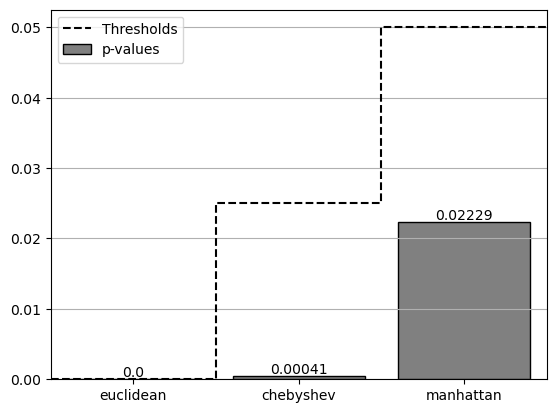

In [88]:
methods = ["euclidean", "manhattan", "chebyshev"]
fixed_params = {"k": 1, "solver":"density"}
dataframe_names, dbscan_distances_df_lower_density = benchmark("./../../data/benchmarks/imb_IRLowerThan9/","distMethod", methods, fixed_params)

In [89]:
means = dbscan_distances_df_lower_density.iloc[:, 1:].mean(axis=0)
print("Max mean of F1 scores: ", means.max(), "Method: ", methods[means.argmax()])

means_row = pd.DataFrame([['MEANS'] + means.tolist()], columns=dbscan_distances_df_lower_density.columns)
dbscan_distances_df_lower_density_with_means = pd.concat([dbscan_distances_df_lower_density, means_row], ignore_index=True)
dbscan_distances_df_lower_density_with_means_color = dbscan_distances_df_lower_density_with_means.style.apply(highlight_max, axis=1)
dbscan_distances_df_lower_density_with_means_color

Max mean of F1 scores:  0.777143720844837 Method:  euclidean


,dataset,euclidean,manhattan,chebyshev
0,ecoli-0_vs_1,0.968961,0.964885,0.968152
1,ecoli1,0.767142,0.736474,0.736549
2,ecoli2,0.707665,0.707665,0.702739
3,ecoli3,0.640679,0.633661,0.613398
4,glass-0-1-2-3_vs_4-5-6,0.847847,0.847847,0.847847
5,glass0,0.642918,0.649821,0.634035
6,glass1,0.585602,0.585602,0.576738
7,glass6,0.825641,0.840793,0.783916
8,haberman,0.484523,0.454691,0.482558
9,iris0,1.000000,1.000000,1.000000


In [90]:
methods = ["euclidean", "manhattan", "chebyshev"]
fixed_params = {"k": 1, "solver":"density"}
dataframe_names, dbscan_distances_df_higher_density = benchmark("./../../data/benchmarks/imb_IRHigherThan9p1/","distMethod", methods, fixed_params)

Processing datasets: 100%|██████████| 21/21 [00:38<00:00,  1.84s/it]


--- Test de Friedman ---
Friedman statistic: 3.4359, p-value: 0.1794, Hypothesis: Fail to Reject H0 with alpha = 0.05 (Same distributions)
Rankings: {'euclidean': 25.023809523809526, 'manhattan': 36.166666666666664, 'chebyshev': 34.80952380952381}


In [91]:
means = dbscan_distances_df_higher_density.iloc[:, 1:].mean(axis=0)
print("Max mean of F1 scores: ", means.max(), "Method: ", methods[means.argmax()])

means_row = pd.DataFrame([['MEANS'] + means.tolist()], columns=dbscan_distances_df_higher_density.columns)
dbscan_distances_df_higher_density_with_means = pd.concat([dbscan_distances_df_higher_density, means_row], ignore_index=True)
dbscan_distances_df_higher_density_with_means_color = dbscan_distances_df_higher_density_with_means.style.apply(highlight_max, axis=1)
dbscan_distances_df_higher_density_with_means_color

Max mean of F1 scores:  0.472820631861225 Method:  euclidean


,dataset,euclidean,manhattan,chebyshev
0,abalone19,0.057618,0.057362,0.053049
1,abalone9-18,0.378418,0.374781,0.375832
2,ecoli-0-1-3-7_vs_2-6,0.626667,0.626667,0.626667
3,ecoli4,0.787994,0.787994,0.800115
4,glass-0-1-6_vs_2,0.205749,0.166484,0.168681
5,glass-0-1-6_vs_5,0.495238,0.495238,0.495238
6,glass2,0.199248,0.164327,0.164327
7,glass4,0.493853,0.493853,0.493853
8,glass5,0.566061,0.566061,0.566061
9,page-blocks-1-3_vs_4,0.786580,0.786580,0.796580


Mean F1 Scores for Lower IR (Mean): 0.7796944052346436
Mean F1 Scores for Lower IR (Density): 0.777143720844837
Mean F1 Scores for Higher IR (Mean): 0.453105126903771
Mean F1 Scores for Higher IR (Density): 0.472820631861225


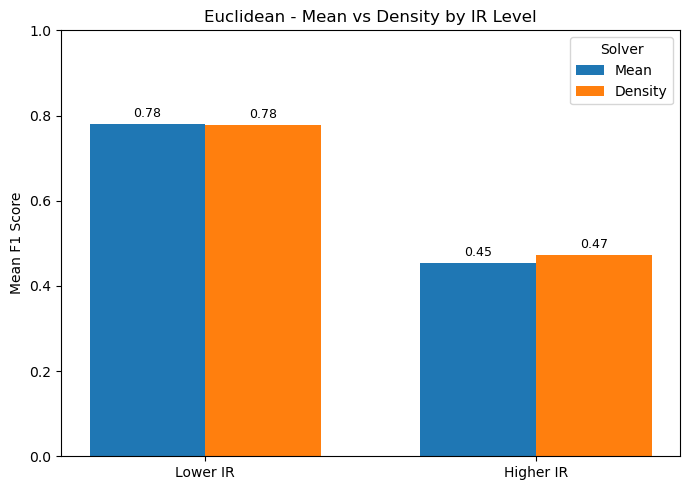

In [92]:
bar_labels = ['Lower IR', 'Higher IR']
mean_scores = [
    dbscan_distances_df_lower_mean['euclidean'].mean(),
    dbscan_distances_df_higher_mean['euclidean'].mean()
]
density_scores = [
    dbscan_distances_df_lower_density['euclidean'].mean(),
    dbscan_distances_df_higher_density['euclidean'].mean()
]

x = range(len(bar_labels))
bar_width = 0.35

fig, ax = plt.subplots(figsize=(7,5))
bars1 = ax.bar([i - bar_width/2 for i in x], mean_scores, width=bar_width, label='Mean', color='#1f77b4')
bars2 = ax.bar([i + bar_width/2 for i in x], density_scores, width=bar_width, label='Density', color='#ff7f0e')

ax.set_ylabel('Mean F1 Score')
ax.set_title('Euclidean - Mean vs Density by IR Level')
ax.set_xticks(x)
ax.set_xticklabels(bar_labels)
ax.set_ylim(0, 1)
ax.legend(title='Solver')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

print("Mean F1 Scores for Lower IR (Mean):", dbscan_distances_df_lower_mean['euclidean'].mean())
print("Mean F1 Scores for Lower IR (Density):", dbscan_distances_df_lower_density['euclidean'].mean())
print("Mean F1 Scores for Higher IR (Mean):", dbscan_distances_df_higher_mean['euclidean'].mean())
print("Mean F1 Scores for Higher IR (Density):", dbscan_distances_df_higher_density['euclidean'].mean())
plt.tight_layout()
plt.show()


In [93]:
methods = ["means", "density"]
fixed_params = {"distMethod":"euclidean", "k": 1}
dataframe_names, dbscan_solver_df_lower = benchmark("./../../data/benchmarks/imb_IRLowerThan9/","solver", methods, fixed_params, selected_columns=["means", "density"])

Processing datasets: 100%|██████████| 22/22 [00:40<00:00,  1.83s/it]


--- Wilcoxon Test ---
Fail to Reject H0 with alpha = 0.1 (Same distributions) with p-value 0.4688451964332787
Ranks: means 113.0 and density 77.0


In [94]:
means = dbscan_solver_df_lower.iloc[:, 1:].mean(axis=0)
print("Max mean of F1 scores: ", means.max())

means_row = pd.DataFrame([['MEANS'] + means.tolist()], columns=dbscan_solver_df_lower.columns)
dbscan_solver_df_lower_with_means = pd.concat([dbscan_solver_df_lower, means_row], ignore_index=True)
dbscan_solver_df_lower_with_means_color = dbscan_solver_df_lower_with_means.style.apply(highlight_max, axis=1)
dbscan_solver_df_lower_with_means_color

Max mean of F1 scores:  0.7796944052346436


,dataset,means,density
0,ecoli-0_vs_1,0.976369,0.968961
1,ecoli1,0.769922,0.767142
2,ecoli2,0.708644,0.707665
3,ecoli3,0.604589,0.640679
4,glass-0-1-2-3_vs_4-5-6,0.832573,0.847847
5,glass0,0.644528,0.642918
6,glass1,0.576912,0.585602
7,glass6,0.812821,0.825641
8,haberman,0.466593,0.484523
9,iris0,1.000000,1.000000


In [95]:
methods = ["means", "density"]
fixed_params = {"distMethod":"euclidean", "k": 1}
dataframe_names, dbscan_solver_df_higher = benchmark("./../../data/benchmarks/imb_IRHigherThan9p1/","solver", methods, fixed_params, selected_columns=["means", "density"])

Processing datasets: 100%|██████████| 21/21 [00:30<00:00,  1.45s/it]


--- Wilcoxon Test ---
Fail to Reject H0 with alpha = 0.1 (Same distributions) with p-value 0.39053287003351755
Ranks: means 82.0 and density 128.0


In [96]:
means = dbscan_solver_df_higher.iloc[:, 1:].mean(axis=0)
print("Max mean of F1 scores: ", means.max())

means_row = pd.DataFrame([['MEANS'] + means.tolist()], columns=dbscan_solver_df_higher.columns)
dbscan_solver_df_higher_with_means = pd.concat([dbscan_solver_df_higher, means_row], ignore_index=True)
dbscan_solver_df_higher_with_means_color = dbscan_solver_df_higher_with_means.style.apply(highlight_max, axis=1)
dbscan_solver_df_higher_with_means_color

Max mean of F1 scores:  0.472820631861225


,dataset,means,density
0,abalone19,0.056061,0.057618
1,abalone9-18,0.428553,0.378418
2,ecoli-0-1-3-7_vs_2-6,0.413333,0.626667
3,ecoli4,0.791111,0.787994
4,glass-0-1-6_vs_2,0.150392,0.205749
5,glass-0-1-6_vs_5,0.411429,0.495238
6,glass2,0.183725,0.199248
7,glass4,0.665714,0.493853
8,glass5,0.322222,0.566061
9,page-blocks-1-3_vs_4,0.695455,0.786580
